# Lab 3: Transfer Learning with Cats vs. Dogs

```{contents}
:depth: 2
```

> Original, from [Keras Developer Guides: Transfer learning & fine-tuning](https://keras.io/guides/transfer_learning/)
>
> Which is itself adapted from [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python)
> and the 2016 blog post ["building powerful image classification models using very little data"](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).
>
> *Author: [fchollet](https://twitter.com/fchollet) Date created: 2020/04/15 Last modified: 2023/06/25*
>
> Adapted for ECE 386 by [byarbrough](https://github.com/byarbrough) with additions from [TensorFlow Tutorials: Transfer learning and fine-tuning](https://www.tensorflow.org/tutorials/images/transfer_learning), cao Jan 2025.

Check out this **Overview** and the complete the **Prelab** below.

## Overview

**Pre-reading video:** [Kaggle: Transfer Learning](https://youtu.be/mPFq5KMxKVw) (only first 5 minutes)

For this lab you will use *transfer learning* to make a general purpose image classification model exceptional at telling the difference between cats vs. dogs!

You will ultimately use this model for live inference with visitors to the classroom!

### Background

```{contents}
:local:
```

#### Introduction

**Transfer learning** consists of taking features learned on one problem, and
leveraging them on a new, similar problem. For instance, features from a model that has
learned to identify racoons may be useful to kick-start a model meant to identify tanukis.

Transfer learning is usually done for tasks where your dataset has too little data to train a full-scale model from scratch.

The most common incarnation of transfer learning in the context of deep learning is the following workflow:

1. Take layers from a previously trained model.
2. Freeze them, so as to avoid destroying any of the information they contain during future training rounds.
3. Add some new, trainable layers on top of the frozen layers.
    They will learn to turn the old features into predictions on a  new dataset.
4. Train the new layers on your dataset.

A last, optional step, is **fine-tuning**, which consists of unfreezing the entire
model you obtained above (or part of it), and re-training it on the new data with a
very low learning rate. This can potentially achieve meaningful improvements, by
incrementally adapting the pretrained features to the new data.

First, we will go over the Keras `trainable` API in detail, which underlies most
transfer learning & fine-tuning workflows.

#### Freezing layers: understanding the `trainable` attribute

Layers & models have three weight attributes:

- `weights` is the list of all weights variables of the layer.
- `trainable_weights` is the list of those that are meant to be updated (via gradient
 descent) to minimize the loss during training.
- `non_trainable_weights` is the list of those that aren't meant to be trained.
 Typically they are updated by the model during the forward pass.

**Example: the `Dense` layer has 2 trainable weights (kernel & bias)**

```python
layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))
```

```text
weights: 2
trainable_weights: 2
non_trainable_weights: 0
```
In general, all weights are trainable weights. The only built-in layer that has
non-trainable weights is the `BatchNormalization` layer.
It uses non-trainable weights to keep track of the mean and variance of its inputs during training.
To learn how to use non-trainable weights in your own custom layers, see the
[guide to writing new layers from scratch](/guides/making_new_layers_and_models_via_subclassing/).

**Example: the `BatchNormalization` layer has 2 trainable weights and 2 non-trainable weights**

```python
layer = keras.layers.BatchNormalization()
layer.build((None, 4))  # Create the weights

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))
```
```text
weights: 4
trainable_weights: 2
non_trainable_weights: 2
```

Layers & models also feature a boolean attribute `trainable`. Its value can be changed.
Setting `layer.trainable` to `False` moves all the layer's weights from trainable to
non-trainable.  This is called "freezing" the layer: the state of a frozen layer won't
be updated during training (either when training with `fit()` or when training with
 any custom loop that relies on `trainable_weights` to apply gradient updates).

**Example: setting `trainable` to `False`**

```python
layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights
layer.trainable = False  # Freeze the layer

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))
```

```text
weights: 2
trainable_weights: 0
non_trainable_weights: 2
```
When a trainable weight becomes non-trainable, its value is no longer updated during training.

```python
# Make a model with 2 layers
layer1 = keras.layers.Dense(3, activation="relu")
layer2 = keras.layers.Dense(3, activation="sigmoid")
model = keras.Sequential([keras.Input(shape=(3,)), layer1, layer2])

# Freeze the first layer
layer1.trainable = False

# Keep a copy of the weights of layer1 for later reference
initial_layer1_weights_values = layer1.get_weights()

# Train the model
model.compile(optimizer="adam", loss="mse")
model.fit(np.random.random((2, 3)), np.random.random((2, 3)))

# Check that the weights of layer1 have not changed during training
final_layer1_weights_values = layer1.get_weights()
np.testing.assert_allclose(
    initial_layer1_weights_values[0], final_layer1_weights_values[0]
)
np.testing.assert_allclose(
    initial_layer1_weights_values[1], final_layer1_weights_values[1]
)
```

```text
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1309
```

Do not confuse the `layer.trainable` attribute with the argument `training` in `layer.__call__()` (which controls whether the layer should run its forward pass in  inference mode or training mode).
For more information, see the [Keras FAQ](https://keras.io/getting_started/faq/#whats-the-difference-between-the-training-argument-in-call-and-the-trainable-attribute).

#### Recursive setting of the `trainable` attribute

If you set `trainable = False` on a model or on any layer that has sublayers,
all children layers become non-trainable as well.

**Example:**

```python
inner_model = keras.Sequential(
    [
        keras.Input(shape=(3,)),
        keras.layers.Dense(3, activation="relu"),
        keras.layers.Dense(3, activation="relu"),
    ]
)

model = keras.Sequential(
    [
        keras.Input(shape=(3,)),
        inner_model,
        keras.layers.Dense(3, activation="sigmoid"),
    ]
)

model.trainable = False  # Freeze the outer model

assert inner_model.trainable == False  # All layers in `model` are now frozen
assert inner_model.layers[0].trainable == False  # `trainable` is propagated recursively
```

#### The typical transfer-learning workflow

This leads us to how a typical transfer learning workflow can be implemented in Keras:

1. Instantiate a base model and load pre-trained weights into it.
2. Freeze all layers in the base model by setting `trainable = False`.
3. Create a new model on top of the output of one (or several) layers from the base
 model.
4. Train your new model on your new dataset.

Note that an alternative, more lightweight workflow could also be:

1. Instantiate a base model and load pre-trained weights into it.
2. Run your new dataset through it and record the output of one (or several) layers
 from the base model. This is called **feature extraction**.
3. Use that output as input data for a new, smaller model.

A key advantage of that second workflow is that you only run the base model once on
your data, rather than once per epoch of training. So it's a lot faster & cheaper.

An issue with that second workflow, though, is that it doesn't allow you to dynamically
modify the input data of your new model during training, which is required when doing
data augmentation, for instance. Transfer learning is typically used for tasks when
your new dataset has too little data to train a full-scale model from scratch, and in
such scenarios data augmentation is very important. So in what follows, we will focus
on the first workflow.

Here's what the first workflow looks like in Keras:

First, instantiate a base model with pre-trained weights.

```python
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.
```

Then, freeze the base model.

```python
base_model.trainable = False
```

Create a new model on top.

```python
inputs = keras.Input(shape=(150, 150, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
```

Train the model on new data.

```python
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])
model.fit(new_dataset, epochs=20, callbacks=..., validation_data=...)
```

#### Fine-tuning

Once your model has converged on the new data, you can try to unfreeze all or part of
the base model and retrain the whole model end-to-end with a very low learning rate.

This is an optional last step that can potentially give you incremental improvements.
It could also potentially lead to quick overfitting -- keep that in mind.

It is critical to only do this step *after* the model with frozen layers has been
trained to convergence. If you mix randomly-initialized trainable layers with
trainable layers that hold pre-trained features, the randomly-initialized layers will
cause very large gradient updates during training, which will destroy your pre-trained
features.

It's also critical to use a very low learning rate at this stage, because
you are training a much larger model than in the first round of training, on a dataset
that is typically very small.
As a result, you are at risk of overfitting very quickly if you apply large weight
updates. Here, you only want to readapt the pretrained weights in an incremental way.

This is how to implement fine-tuning of the whole base model:

```python
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

# Train end-to-end. Be careful to stop before you overfit!
model.fit(new_dataset, epochs=10, callbacks=..., validation_data=...)
```

**Important note about `compile()` and `trainable`**

Calling `compile()` on a model is meant to "freeze" the behavior of that model. This
implies that the `trainable`
attribute values at the time the model is compiled should be preserved throughout the
lifetime of that model,
until `compile` is called again. Hence, if you change any `trainable` value, make sure
to call `compile()` again on your
model for your changes to be taken into account.

**Important notes about `BatchNormalization` layer**

Many image models contain `BatchNormalization` layers. That layer is a special case on
every imaginable count. Here are a few things to keep in mind.

- `BatchNormalization` contains 2 non-trainable weights that get updated during
training. These are the variables tracking the mean and variance of the inputs.
- When you set `bn_layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean & variance statistics. This is not the case for other layers in general, as [weight trainability & inference/training modes are two orthogonal concepts](https://keras.io/getting_started/faq/#whats-the-difference-between-the-training-argument-in-call-and-the-trainable-attribute). But the two are tied in the case of the `BatchNormalization` layer.
- When you unfreeze a model that contains `BatchNormalization` layers in order to do fine-tuning, you should keep the `BatchNormalization` layers in inference mode by passing `training=False` when calling the base model. Otherwise the updates applied to the non-trainable weights will suddenly destroy what the model has learned.

---

## Pre-lab

```{contents}
:local:
```

For the pre-lab, follow this end-to-end example: fine-tuning an image classification model on a cats vs. dogs dataset

1. Watch the pre-reading video.
2. Load and explore the dataset.
3. Load the MobileNet model.
4. Perform transfer learning on the model.
5. Save a copy of the model for use in the lab.

In [1]:
import keras
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

tf.random.set_seed(2016)  # For reproducability

print("Running Tensorflow version", tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")

print("Found GPU at: {}".format(device_name))

Running Tensorflow version 2.18.0
Found GPU at: /device:GPU:0


### Getting the data

First, let's fetch the cats vs. dogs dataset using TFDS. If you have your own dataset,
you'll probably want to use the utility
`keras.utils.image_dataset_from_directory` to generate similar labeled
 dataset objects from a set of images on disk filed into class-specific folders.

Transfer learning is most useful when working with very small datasets. To keep our
dataset small, we will use 40% of the original training data (25,000 images) for
 training, 10% for validation, and 10% for testing.

In [2]:
tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print(f"Number of training samples: {train_ds.cardinality()}")
print(f"Number of validation samples: {validation_ds.cardinality()}")
print(f"Number of test samples: {test_ds.cardinality()}")
print(f"Dtype of training samles: {train_ds.element_spec[0]}")
print(f"Dtype of training labels: {train_ds.element_spec[1]}")

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326
Dtype of training samles: TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None)
Dtype of training labels: TensorSpec(shape=(), dtype=tf.int64, name=None)


These are the first 9 images in the training dataset -- as you can see, they're all
different sizes.

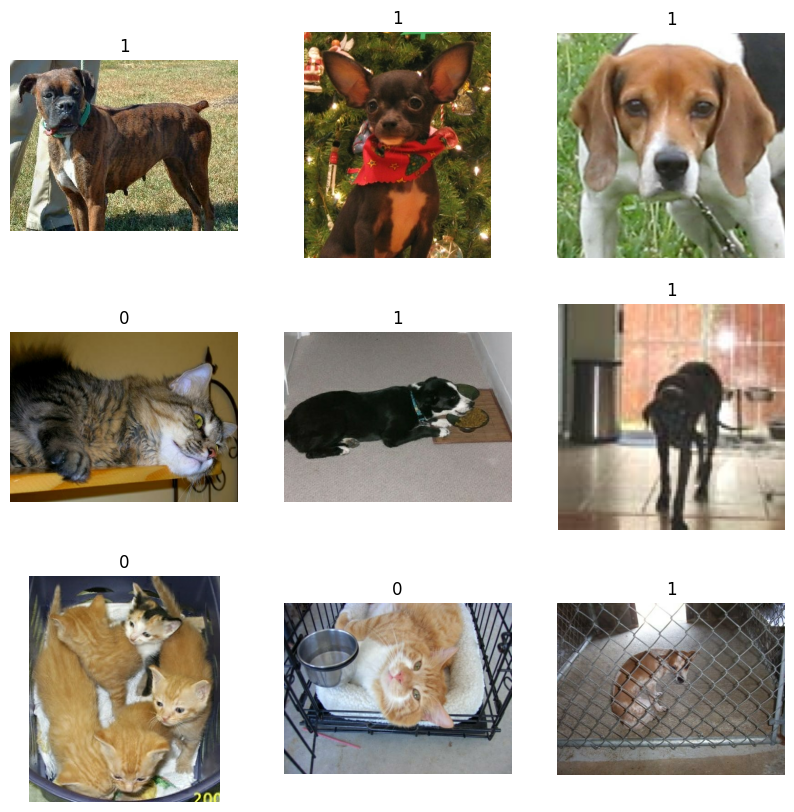

In [3]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

We can also see that label 1 is "dog" and label 0 is "cat".

#### Standardizing the data

Our raw images have a variety of sizes. In addition, each pixel consists of 3 integer
values between 0 and 255 (RGB level values). This isn't a great fit for feeding a
neural network. We need to do 2 things:

- Standardize to a fixed image size. We pick 150x150.
- Normalize pixel values to what the model expects. We'll do this using a layer within the model itself.

In general, it's a good practice to develop models that take raw data as input, as
opposed to models that take already-preprocessed data. The reason being that, if your
model expects preprocessed data, any time you export your model to use it elsewhere
(in a web browser, in a mobile app), you'll need to reimplement the exact same
preprocessing pipeline. This gets very tricky very quickly. So we should do the least
 possible amount of preprocessing before hitting the model.

Here, we'll do image resizing in the data pipeline (because a deep neural network can
only process contiguous batches of data), and we'll do the input value scaling as part
of the model, when we create it.

Let's resize images to 150x150:

In [4]:
resize_fn = keras.layers.Resizing(150, 150, dtype=tf.uint8)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))

In [5]:
print(f"Training set {train_ds.element_spec[0]}")

Training set TensorSpec(shape=(150, 150, 3), dtype=tf.uint8, name=None)


#### Using random data augmentation

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to
the training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
overfitting.

In [6]:
# Cache loads the dataset into memory
train_ds = train_ds.cache()

augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


# This map means data_augmentation will be called when the dataset is iterated
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

Let's batch the data and use prefetching to optimize loading speed.

In [7]:
from tensorflow import data as tf_data

batch_size = 64

train_ds = train_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE)
validation_ds = validation_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
test_ds = test_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()

In [8]:
print(f"Number of training batches: {train_ds.cardinality()}")
print(f"Number of validation batches: {validation_ds.cardinality()}")
print(f"Number of test batches: {test_ds.cardinality()}")

Number of training batches: 146
Number of validation batches: 37
Number of test batches: 37


Let's visualize what the first image of the first batch looks like after various random
 transformations:

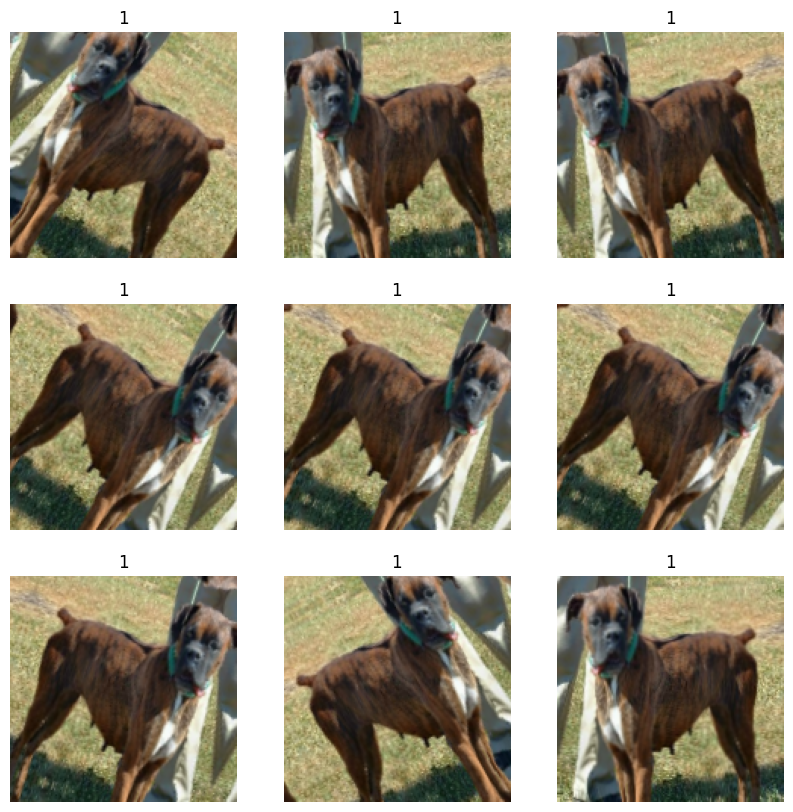

In [9]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

### Build a model

Now let's built a model that follows the blueprint we've explained earlier.

Note that:

- We add a `Rescaling` layer to scale input values (initially in the `[0, 255]`
 range) to the `[-1, 1]` range.
- We add a `Dropout` layer before the classification layer, for regularization.
- We make sure to pass `training=False` when calling the base model, so that
it runs in inference mode, so that batchnorm statistics don't get updated
even after we unfreeze the base model for fine-tuning.

We will make the input data type `uint8` since that's what our webcam will eventually capture.

In [10]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(150, 150, 3), include_top=False, weights="imagenet"
)

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3), dtype=tf.uint8, name="catdog_input")

# Pre-trained MobileNetV2 weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

x = preprocess_input(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

<ipython-input-10-7274d0d8f078>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ catdog_input (InputLayer)           │ (None, 150, 150, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ true_divide (TrueDivide)            │ (None, 150, 150, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ subtract (Subtract)                 │ (None, 150, 150, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mobilenetv2_1.00_224 (Functional)   │ (None, 5, 5, 1280)           │     2,257,984 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_average_pooling2d            │ (None, 1280)                 │             0 │    -    │
│ (GlobalAveragePooling2D)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout (Dropout)                   │ (None, 1280)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense (Dense)                       │ (None, 1)                    │         1,281 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Train the top layer

In [11]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name="accuracy")],
)

In [12]:
initial_epochs = 10

print("Fitting the top layer of the model")
history = model.fit(train_ds, epochs=initial_epochs, validation_data=validation_ds)

Fitting the top layer of the model
Epoch 1/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 67s 379ms/step - accuracy: 0.7929 - loss: 0.4167 - val_accuracy: 0.9643 - val_loss: 0.0886
Epoch 2/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 54s 236ms/step - accuracy: 0.9397 - loss: 0.1397 - val_accuracy: 0.9725 - val_loss: 0.0747
Epoch 3/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 34s 234ms/step - accuracy: 0.9538 - loss: 0.1191 - val_accuracy: 0.9746 - val_loss: 0.0733
Epoch 4/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 34s 230ms/step - accuracy: 0.9504 - loss: 0.1221 - val_accuracy: 0.9759 - val_loss: 0.0688
Epoch 5/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 41s 233ms/step - accuracy: 0.9527 - loss: 0.1089 - val_accuracy: 0.9733 - val_loss: 0.0770
Epoch 6/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 41s 234ms/step - accuracy: 0.9541 - loss: 0.1083 - val_accuracy: 0.9764 - val_loss: 0.0688
Epoch 7/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 35s 238ms/step - accuracy: 0.9562 - loss: 0.1036 - val_accuracy: 0.9738 - val_loss: 0.0771
Epoch 8/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 40s 231m

#### Learning Curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

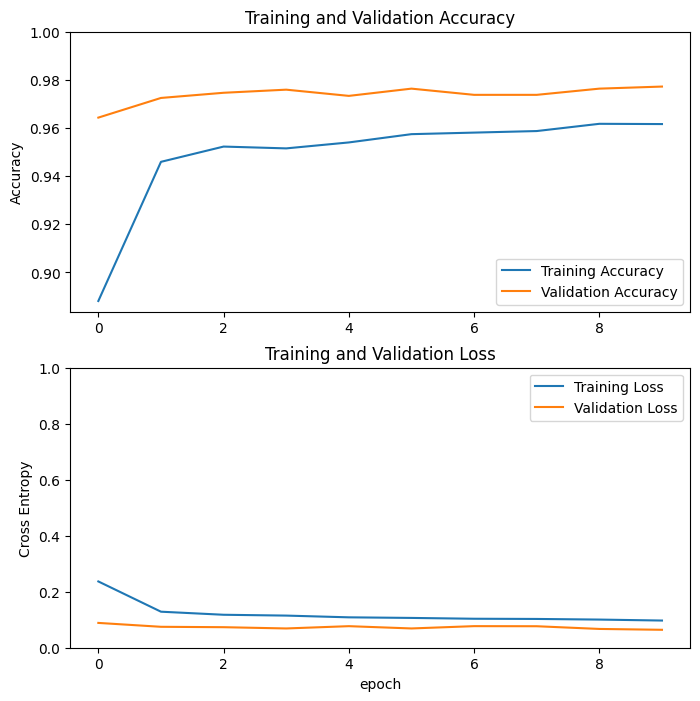

In [13]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.ylim([min(plt.ylim()), 1])
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.ylabel("Cross Entropy")
plt.ylim([0, 1.0])
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

### Fine-tuning the entire model

Finally, let's unfreeze the base model and train the entire model end-to-end with a low learning rate.

Importantly, although the base model becomes trainable, it is still running in
inference mode since we passed `training=False` when calling it when we built the
model. This means that the batch normalization layers inside won't update their batch
statistics. If they did, they would wreck havoc on the representations learned by the model so far.

In [14]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name="accuracy")],
)

fine_epochs = 5
print("Fitting the end-to-end model")
history_fine = model.fit(train_ds, epochs=fine_epochs, validation_data=validation_ds)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ catdog_input (InputLayer)           │ (None, 150, 150, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ true_divide (TrueDivide)            │ (None, 150, 150, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ subtract (Subtract)                 │ (None, 150, 150, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mobilenetv2_1.00_224 (Functional)   │ (None, 5, 5, 1280)           │     2,257,984 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_average_pooling2d            │ (None, 1280)                 │             0 │    -    │
│ (GlobalAveragePooling2D)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout (Dropout)                   │ (None, 1280)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense (Dense)                       │ (None, 1)                    │         1,281 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 2,261,829 (8.63 MB)

 Trainable params: 2,225,153 (8.49 MB)

 Non-trainable params: 34,112 (133.25 KB)

 Optimizer params: 2,564 (10.02 KB)

Fitting the end-to-end model
Epoch 1/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 119s 463ms/step - accuracy: 0.8554 - loss: 0.3665 - val_accuracy: 0.9579 - val_loss: 0.1355
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 43s 294ms/step - accuracy: 0.9343 - loss: 0.1684 - val_accuracy: 0.9617 - val_loss: 0.1156
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 43s 293ms/step - accuracy: 0.9455 - loss: 0.1333 - val_accuracy: 0.9699 - val_loss: 0.0890
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 82s 292ms/step - accuracy: 0.9534 - loss: 0.1152 - val_accuracy: 0.9729 - val_loss: 0.0765
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 43s 294ms/step - accuracy: 0.9575 - loss: 0.1048 - val_accuracy: 0.9751 - val_loss: 0.0667


After a few epochs, fine-tuning gains us a nice improvement here.
Let's evaluate the model on the test dataset:

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.

In [15]:
acc += history_fine.history["accuracy"]
val_acc += history_fine.history["val_accuracy"]

loss += history_fine.history["loss"]
val_loss += history_fine.history["val_loss"]

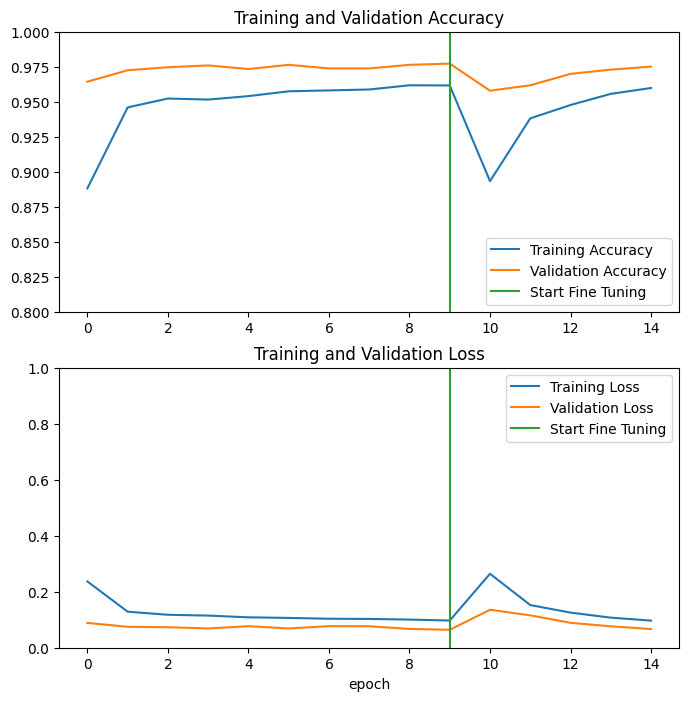

In [16]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.ylim([0.8, 1])
plt.plot(
    [initial_epochs - 1, initial_epochs - 1], plt.ylim(), label="Start Fine Tuning"
)
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.ylim([0, 1.0])
plt.plot(
    [initial_epochs - 1, initial_epochs - 1], plt.ylim(), label="Start Fine Tuning"
)
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

#### Test

Evaluate the final model against the test set!

In [17]:
test_loss, test_accuracy = model.evaluate(test_ds)

print("Test loss: {:.2f}".format(test_loss))
print("Test accuracy: {:.2f}".format(test_accuracy))

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.9730 - loss: 0.0821
Test loss: 0.09
Test accuracy: 0.97


Predict if your pet is a cat or dog!

Predictions:
 [0 1 1 1 0 1 1 1 0 1 0 1 0 0 0 1 0 1 0 1 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 1 1
 1 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 1 1 1 0 1 0 1 1 1 0 1]
Labels:
 [0 1 1 1 1 1 1 1 0 1 0 1 0 0 0 1 0 1 0 1 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 1 1
 1 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 1 1 1 0 1 0 1 1 1 0 1]


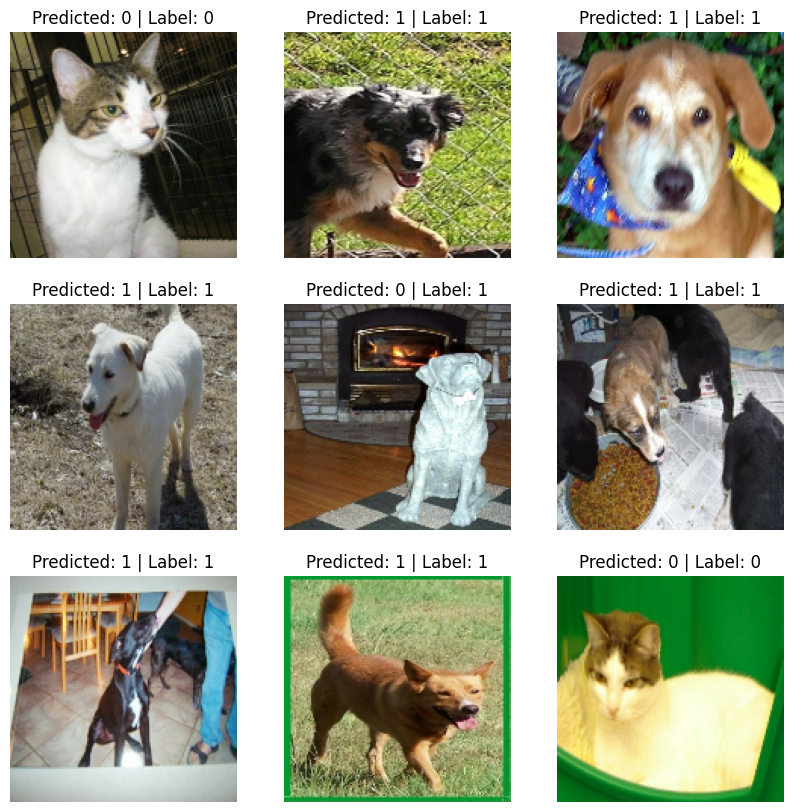

In [19]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print("Predictions:\n", predictions.numpy())
print("Labels:\n", label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title("Predicted: {} | Label: {}".format(predictions[i], label_batch[i]))
    plt.axis("off")

### Save the Model

We don't want to lose our work once our Colab instance shuts down! Zip the full Keras model and then download it.

In [21]:
# Save the model
model_name = "cat-dog-mnv2.keras"
model.save(model_name)
!zip -r cat-dog-mnv2.zip cat-dog-mnv2.keras
from google.colab import files
files.download("cat-dog-mnv2.zip")  # If zipped


  adding: cat-dog-mnv2.keras (deflated 10%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Download** your model to your local computer!

- You can use `scp` to move it between devices
- You can use [`keras.saving.load_model()`](https://keras.io/api/models/model_saving_apis/model_saving_and_loading/) to load the saved model

### TensorFlow Lite Conversion

We will ultimately be executing this model on the Raspberry Pi 5, which is well-suited to TensorFlow Lite
([which is now LiteRT](https://developers.googleblog.com/en/tensorflow-lite-is-now-litert/))

When we do this we will use the default [full integer quantizaiton of weights and activations](https://www.tensorflow.org/model_optimization/guide/quantization/post_training)

In [23]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Default optimization to int8
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Show size of converted model in MB
print("Model size in MB:", len(tflite_model) / 1024 / 1024)

tflite_model_path = "cat-dog-mnv2.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print("Model written to", tflite_model_path)

# Save the TFLite model
tflite_model_path = "cat-dog-mnv2.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

# Zip the TFLite model (optional)
!zip -r cat-dog-mnv2-tflite.zip cat-dog-mnv2.tflite

# Download the TFLite model
from google.colab import files
files.download("cat-dog-mnv2-tflite.zip")  # If zipped


Saved artifact at '/tmp/tmplq779wzd'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.uint8, name='catdog_input')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135950752410576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135950752413648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135950752413456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135950752412880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135950752414224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135950752407120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135950752415376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135950752412688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135950752414800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135950752415184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135951151399376:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Lab

Our goals for the lab are to:

1. Deploy tflite models to a Raspberry Pi using [LiteRT](https://ai.google.dev/edge/litert)
2. Benchmark MobilenetV2 vs. MobilenetV3Small
3. Conduct live inference of cats vs. dogs!!!

## LiteRT

The full TensorFlow package is for *training* models or conducting inference in a cloud environment.

For an edge inference deployment we want something lighter weight... meaning compute and memory optimized for constrained devices.

Google pioneered this with TensorFlow Lite, which has since [been re-imagined as LiteRT](https://developers.googleblog.com/en/tensorflow-lite-is-now-litert/).

Although it supports PyTorch and JAX, LiteRT is baked into TensorFlow, so we can directly test our model prior to deploying to an edge device!

> LiteRT inference typically follows the following steps:
>
> 1. **Loading a model:** load the `.tflite` model into memory, which contains the model's execution graph.
> 2. **Transforming data:** Transform input data into the expected format and dimensions. Raw input data for the model generally does not match the input data format expected by the model. For example, you might need to resize an image or change the image format to be compatible with the model.
> 3. **Running inference:** Execute the LiteRT model to make predictions. This step involves using the LiteRT API to execute the model. It involves a few steps such as building the interpreter, and allocating tensors.
> 4. **Interpreting output:** Interpret the output tensors in a meaningful way that's useful in your application. For example, a model might return only a list of probabilities. It's up to you to map the probabilities to relevant categories and format the output.
>
> ~ [Get started with LiteRT](https://ai.google.dev/edge/litert/inference)


### Signatures

If you read [LiteRT Python](https://ai.google.dev/edge/litert/inference#run-python) and [Signatures in LiteRT](https://ai.google.dev/edge/litert/models/signatures)... it only sort of helps. And because this software is so new, the LLMs of the world only sort of help. So we'll walk through it.

To run LiteRT inference we need an [**interpreter**](https://www.tensorflow.org/api_docs/python/tf/lite/Interpreter) that will load the model, manage memory, and can be invoked to process a sample through the model's graph.

> The LiteRT interpreter uses a static graph ordering and a custom (less-dynamic) memory allocator to ensure minimal load, initialization, and execution latency.

*Signatures* are the input and output specifications for a TensorFlow model.

Signatures must be retained when converting the model from TensorFlow to tflite, but the [Keras model converter API uses the default signatures automatically](https://ai.google.dev/edge/litert/models/signatures#from_keras_model). That's good for us!

Before running this cell, upload your `cat-dog-mnv2.tflite` model to wherever your notebook is running, if it's not already there.

In [ ]:
# This import is for testing with the TensorFlow only.
# On the Pi you will need to use from ai_edge_litert.interpreter import Interpreter
from tensorflow import lite
from typing import Any

# Open the model
model_path = "cat-dog-mnv2.tflite"
interpreter = lite.Interpreter(model_path=model_path)
# Allocate the model in memory. Should always be called before doing inference
interpreter.allocate_tensors()

# Show the model's signature dict
signatures = interpreter.get_signature_list()
print(signatures)

This should print something like this (expanded here to be easier to see).

```json
{
    'serving_default': {
        'inputs': ['catdog_input'],
        'outputs': ['output_0']
        }
}
```

It is possible to have multiple inputs/outputs to a model, but ours has just one. What we really need are the details for `inputs` and `outputs`, such as the expected **shape**.

### Invoking


```{note}
I'm reasonably sure that `serving_default` is a reliable key, but if your signature key is different make sure you change it below.
```

We will create a Signature Runner for invoking our model.

```{hint}
The input and output details are extremely helpful for debugging!
```

In [ ]:
# Create callable object that runs inference based on signatures
fn = interpreter.get_signature_runner(
    "serving_default"
)  # Must match top level key from get_signature_list()

# Print input and output details
print(f"Input details:\n{fn.get_input_details()}")
print(f"Output details:\n{fn.get_output_details()}")

As a test, let's just give the model a random numpy array of the correct shape!


In [ ]:
import numpy as np

# Should match the shape from catdog_input[shape]
sample = np.random.random_sample((1, 150, 150, 3)).astype(np.uint8)
print(sample.shape)

In [ ]:
# Invoke inference
output = fn(catdog_input=sample)  # Key matches top key from get_input_details()
# Extract the result fom the batch returned
result = output["output_0"][0][0]  # Key matches top key from get_output_details()

print(result)

### LiteRT Summary

That was a lot. Let's break it down again:

1. We opened our `tflite` model via a LiteRT [Interpreter](https://www.tensorflow.org/api_docs/python/tf/lite/Interpreter).
2. We called `interpreter.allocate_tensors()` to reserve space in memory for our model. The input and output layers will be static, while the runtime intelligently manages the hidden layers in the constrained memory.
3. We used `get_signature_list()` to view the labels given to our input and output layers by Keras during model conversion.
4. We provided those signatures to `get_signature_runner()`, which created an object that can use the input and output details of the signature to easily invoke the model.
5. We conducted inference on our model by calling the Signature Runner object and passing a data sample to the input signature.

```{important}
Reminder that this demo was with the full install of TensorFlow. On your edge device you should be
[installing LiteRT](https://pypi.org/project/ai-edge-litert/)

~~~bash
pip install ai-edge-litert
~~~

Then import

~~~python
from ai_edge_litert.interpreter import Interpreter
~~~
```


# 🐱 🐶 Live Inference

Deliverables:

- Upload your code to a GitHub repository and submit to Gradescope

## Using Webcam

We will use the popular OpenCV library to take a picture with the webcam and convert it to numpy.

Be aware that opencv takes pictures in blue-green-red (BGR) format, which needs to be converted to RGB for... anybody that's sane.

Here is a demo that should work on your Pi if you have a webcam connected via USB.

In [ ]:
%pip install -q opencv-python

In [ ]:
import cv2
import numpy as np

# Initialize the camera
cap = cv2.VideoCapture(0)  # 0 is the default camera index

# Capture a frame
ret, frame = cap.read()

# Release the camera
cap.release()

# Only process of ret is True
if ret:
    # Convert BGR (OpenCV default) to RGB for TFLite
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Convert to a NumPy array
    img_array = np.array(frame_rgb, dtype=np.uint8)
    print("Image shape:", img_array.shape)  # Ensure shape matches model input

    # Preview the image
    cv2.imshow("Captured Image", frame)
    print("Press any key to exit.")
    while True:
        # Window stays open until key press
        if cv2.waitKey(0):
            cv2.destroyAllWindows()
            break

else:
    print("Failed to capture image.")